In [1]:
%load_ext autoreload
%autoreload 2

# Training part

#### Make sure you downloaded coco, flickr, glove. If not uncomment cell below.

In [ ]:
#!bash ../load_flickr8k.sh
#!bash ../load_glove.sh
#!bash ../load_coco.sh

In [14]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [ ]:
import nltk
nltk.download('punkt')

In [12]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [15]:
import pickle

from datasets.flickr8k import Flickr8kDataset


DATASET_BASE_PATH = '../data/flickr8k/'
VOCAB = 'vocab_set.pkl'

train_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train',
    device=device, return_type='tensor', load_img_to_memory=False)


vocab_set = train_set.get_vocab()
with open(VOCAB, 'wb') as f:
    pickle.dump(vocab_set, f)
    

vocab, word2idx, idx2word, max_len = vocab_set
vocab_size = len(vocab)

val_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='val', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

test_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='test', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)

train_eval_set = Flickr8kDataset(
    dataset_base_path=DATASET_BASE_PATH, dist='train', vocab_set=vocab_set,
    device=device, return_type='corpus', load_img_to_memory=False)


print(
    f"The number of samples in:\ntrain: {len(train_set)};"
    + f" validation: {len(val_set)}; test: {len(test_set)}\n"
    + f"Vocabulary size: {vocab_size}; Max length of a sentence: {max_len};"
)

The number of samples in:
train: 30000; validation: 1000; test: 1000
Vocabulary size: 7708; Max length of a sentence: 40;


In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.coco import CoCoDataloader

BATCH_SIZE = 50

eval_transformations = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

val_set.transformations = eval_transformations
test_set.transformations = eval_transformations
train_eval_set.transformations = eval_transformations

eval_collate_fn = lambda batch: (torch.stack([x[0] for x in batch]), [x[1] for x in batch], [x[2] for x in batch])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, sampler=None, pin_memory=False, drop_last=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, sampler=None, pin_memory=False,
                        collate_fn=eval_collate_fn, drop_last=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, sampler=None, pin_memory=False,
                         collate_fn=eval_collate_fn, drop_last=True)
train_eval_loader = DataLoader(train_eval_set, batch_size=1, shuffle=False, sampler=None, pin_memory=False,
                               collate_fn=eval_collate_fn, drop_last=True) # due to cuda memory issue I choose batch size 1

vocab_from_file = True     # if True, load existing vocab file


coco_val_loader = CoCoDataloader(transform=eval_transformations,
                        batch_size=BATCH_SIZE,
                        vocab_from_file=vocab_from_file,
                        vocab_file='vocab_set.pkl',
                        img_folder='../data/coco/val2014',
                        annotations_file='../data/coco/annotations/captions_val2014.json')

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [18]:
start_token = word2idx['<start>']
end_token = word2idx['<end>']
pad_token = word2idx['<pad>']
max_seq_len = max_len

In [20]:
import random
import torch
import numpy as np
from models.torch.vit_transformer import Captioner

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [22]:
from glove import embedding_matrix_creator
EMBEDDING_DIM = 200
EMBEDDING = f"GLV{EMBEDDING_DIM}"

embedding_matrix = embedding_matrix_creator(embedding_dim=EMBEDDING_DIM, word2idx=word2idx, GLOVE_DIR='../data/glove.6B/')
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7708/7708 [00:00<00:00, 179335.43it/s]


Embedding matrix shape: (7708, 200)


In [ ]:
final_model = Captioner(20, 6, EMBEDDING_DIM, vocab_size, embedding_matrix, False, device=device).to(device)

In [12]:
import torch
from train_torch import evaluate_model
from train_transformer import train_model

In [8]:
from utils_torch import check_create_dir
from metrics import *
from utils_torch import *
import numpy as np

In [14]:
#If you want to do inference only then skip this cell
MODEL = final_model.name
train_from_scratch = False

if train_from_scratch:
    check_create_dir(f'saved_models/{MODEL}')
    MODEL_NAME = f'saved_models/{MODEL}/{MODEL}_b{BATCH_SIZE}_emd{EMBEDDING}'
    NUM_EPOCHS = 20
    print(MODEL_NAME)

    
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_set.pad_value)
    acc_fn = accuracy_fn(ignore_value=train_set.pad_value)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)

    min_val_loss = np.float('Inf')

    sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
    corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
    tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)
    train_loss_min = np.float('Inf')
    val_bleu4_max = 0.0

    for epoch in range(NUM_EPOCHS):
        train_loss = train_model(
            desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}',
            model=final_model,                                                                      
            optimizer=optimizer,
            loss_fn=loss_fn,                                        
            train_loader=train_loader,
            acc_fn=acc_fn,
            pad_token=pad_token
        )


        with torch.no_grad():
            train_bleu = evaluate_model(
                desc=f'\tTrain Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=train_eval_loader,
                device=device
            )

            val_bleu = evaluate_model(
                desc=f'\tValidation Bleu Score: ',
                model=final_model,
                bleu_score_fn=corpus_bleu_score_fn,
                tensor_to_word_fn=tensor_to_word_fn,
                data_loader=val_loader,
                device=device
            )

            print(f'Epoch {epoch + 1}/{NUM_EPOCHS}',
                ''.join([f'train_bleu{i}: {train_bleu[i]:.4f} ' for i in (1, 4)]),
                ''.join([f'val_bleu{i}: {val_bleu[i]:.4f} ' for i in (1, 4)]),
                )
            
            state = {
                'epoch': epoch + 1,
                'state_dict': final_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss_latest': train_loss,
                'val_bleu4_latest': val_bleu[4],
                'train_loss_min': min(train_loss, train_loss_min),
                'val_bleu4_max': max(val_bleu[4], val_bleu4_max),
                'train_bleus': train_bleu,
                'val_bleus': val_bleu
            }

            torch.save(state, f'{MODEL_NAME}_latest.pt')

            if train_loss < train_loss_min:
                train_loss_min = train_loss
                torch.save(state, f'{MODEL_NAME}''_best_train_loss.pt')
            
            if epoch == 19:
                torch.save(state, f'{MODEL_NAME}''_20_epoch.pt')
                
            if val_bleu[4] > val_bleu4_max:
                val_bleu4_max = val_bleu[4]
                torch.save(state, f'{MODEL_NAME}''_best_val_bleu.pt')
        scheduler.step(train_loss)

    torch.save(state, f'{MODEL_NAME}_ep{NUM_EPOCHS:02d}_weights.pt')

# Inference part

In [15]:
sentence_bleu_score_fn = bleu_score_fn(4, 'sentence')
corpus_bleu_score_fn = bleu_score_fn(4, 'corpus')
tensor_to_word_fn = words_from_tensors_fn(idx2word=idx2word)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=train_set.pad_value)

In [ ]:
"""
If you want to evaluate your trained model just ignore this cell
"""

! gdown 1-UG4VYY-I5LQbKqp227velrF5EB9jHH3
!mkdir -p saved_models/diet_transformer
!mv diet_transformer_b50_emdGLV200_best_val_bleu.pt saved_models/diet_transformer/diet_transformer_b50_emdGLV200_best_val_bleu.pt

In [ ]:
NUM_HEADS_DEC = 20
NUM_LAYERS_DEC = 6

path = 'saved_models/diet_transformer/diet_transformer_b50_emdGLV200_best_val_bleu.pt'
checkpoint = torch.load(path)
model = Captioner(NUM_HEADS_DEC, NUM_LAYERS_DEC, EMBEDDING_DIM, vocab_size, embedding_matrix, False).to(device)
model.decoder.pos_encoder.pe = model.decoder.pos_encoder.pe.repeat(50, 1, 1).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

### Flickr

In [18]:
inter_params = {
    'model': model,
    'bleu_score_fn': corpus_bleu_score_fn,
    'tensor_to_word_fn': tensor_to_word_fn,
    'data': 'flickr',
    'device': device
}

with torch.no_grad():
    model.eval()
    train_bleu = evaluate_model(
        desc=f'Train: ',
        data_loader=train_eval_loader,
        **inter_params,
    )
    
    val_bleu = evaluate_model(
        desc=f'Val: ',
        data_loader=val_loader,
        **inter_params,
    )
    
    test_bleu = evaluate_model(
        desc=f'Test: ',
        data_loader=test_loader,
        **inter_params,
    )
    print()
    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(setname, end=' ')
        for ngram in (1, 2, 3, 4):
            print(f'Bleu-{ngram}: {result[ngram]}', end=' ')
        print()

Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Val:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]


train Bleu-1: 0.7096718798697716 Bleu-2: 0.5381619576111102 Bleu-3: 0.42643202495214255 Bleu-4: 0.35486062152248843 
val Bleu-1: 0.6322255088026739 Bleu-2: 0.44241607232178143 Bleu-3: 0.35049916075736776 Bleu-4: 0.29716701421433916 
test Bleu-1: 0.6273392904988381 Bleu-2: 0.4412329864803093 Bleu-3: 0.35161539449119694 Bleu-4: 0.29883420659389653 


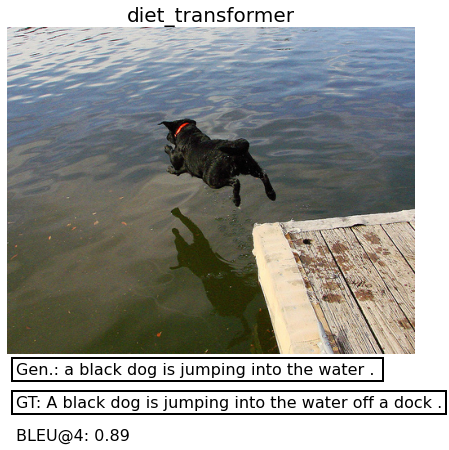

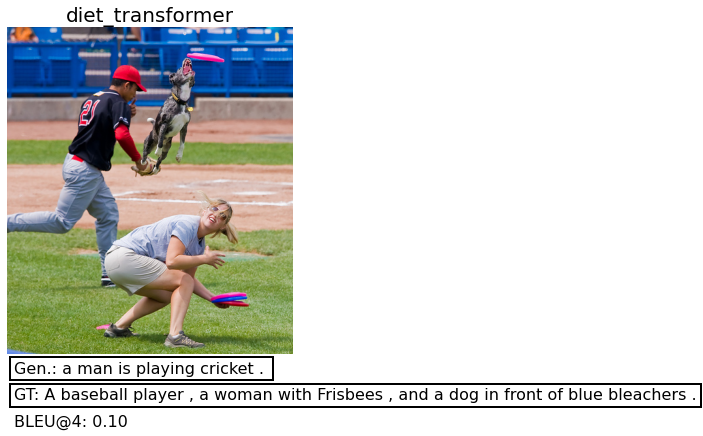

In [20]:
from utils_plot import *
dset = val_set
spatial = (
    ((10, 425), (10, 465), (10, 505)),
    ((10, 530), (10, 570), (10, 610))
)


idx_range = get_best_and_worst_quality_camptions(dset, model, idx2word, bleu_score_fn(4, 'corpus'))

idx2spatial = {i:v for i, v in zip(idx_range, spatial)}
display_images_with_captions(idx2spatial, dset, model, idx2word, bleu_score_fn(4, 'corpus'))

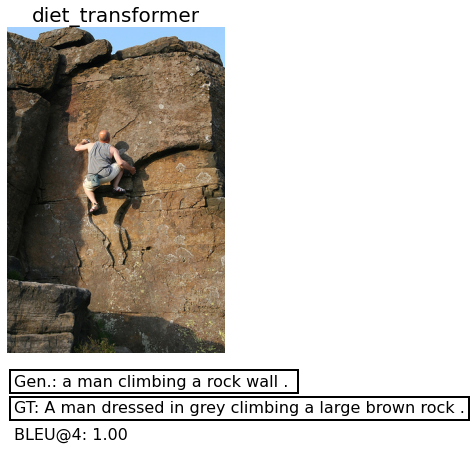

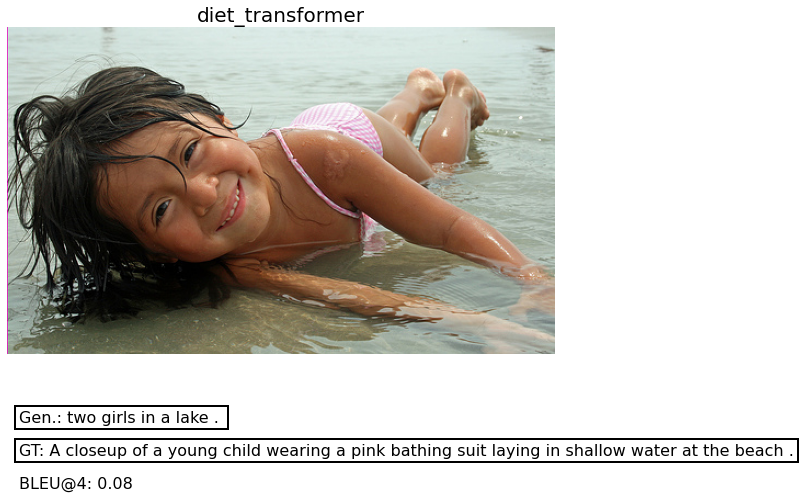

In [26]:
dset = test_set
spatial = (
    ((10, 550), (10, 590), (10, 630)),
    ((10, 360), (10, 390), (10, 420)),
)

 
idx_range = idx_range = get_best_and_worst_quality_captions(dset, model, idx2word, bleu_score_fn(4, 'corpus'))

idx2spatial = {i:v for i, v in zip(idx_range, spatial)}
display_images_with_captions(idx2spatial, dset, model, idx2word, bleu_score_fn(4, 'corpus'))

### COCO

In [16]:
with torch.no_grad():
    val_bleu = evaluate_model(
                    desc=f'\tValidation Bleu Score: ',
                    model=model,
                    data='coco',
                    bleu_score_fn=corpus_bleu_score_fn,
                    tensor_to_word_fn=tensor_to_word_fn,
                    data_loader=coco_val_loader,
                    device=device
                )
    print('val', end=' ')
    for ngram in (1, 2, 3, 4):
        print(f'Bleu-{ngram}: {val_bleu[ngram]}', end=' ')

	Validation Bleu Score:   0%|          | 0/811 [00:00<?, ?it/s]


val Bleu-1: 0.5309882526721591 Bleu-2: 0.29765480047940357 Bleu-3: 0.1692927843313864 Bleu-4: 0.09956766874429145 
